<a href="https://colab.research.google.com/github/furk4neg3/Sales-Forecasting/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmart Sales Forecasting

🐈 In this notebook, I've tried to predict Walmart's upcoming sales using various data and models.

🫒 Dataset has Store,	Dept, Date,	IsHoliday,	Temperature,	Fuel_Price,	CPI,	Unemployment and Type as extra features, and I've used all of those in my models. Additionally, I've added Year, Month and Day attributes as features to data too.

🫒 All data operations are done by me, and to be honest, hardest part of this notebook was organizing the data in the way that I wanted to use it. So I recommend checking these parts too.

🫒 First model is naive model which predicts that the next week's sales will be the same as previous week's sales. In general, that's a tough model to beat.

🫒 Second model is a simple dense model. This model predicts next weeks sales using extra informations.

🫒 Before third model, I've done windowing. With that, third model predicts next week's sales usign extra informations and last 7 weeks sales. Model architecture is the same as model 2.

🫒 You can ask, why 7 weeks? To be honest, that's force of habit. When working with daily data, we use last week's (7 days) data to predict next day's data. I've done the same thing for weeks. In the following model, same "force of habit" goes on, like using 30 weeks to predict 7 weeks. As you can predict, that's habit of predicting next week using last month.

🫒 In fourth model, I've changed window size and horizon again. This model predicts next 7 weeks sales based on last 30 weeks sales. This model performed much better than previous ones.

🫒 Fifth model is an LSTM model with average pooling and dense layers. Window size and horizon is the same.

🫒 Last model is a GRU model with the same architecture as model 5, only feature that changed is that I've used GRU instead of LSTM.

🫒 At the end of the notebook, performance of models are visualized for comparison.

## Receiving Data

🐈 Receiving Wallmart sales forecasting data from Kaggle.

In [ ]:
# Preparing the notebook to be able to load the dataset
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()# I've expired the key before uploading the project to GitHub

Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"furkanegecannizam","key":"d4a1bbc0095bc824153ebed3d3882155"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d aslanahmedov/walmart-sales-forecast

Dataset URL: https://www.kaggle.com/datasets/aslanahmedov/walmart-sales-forecast
License(s): copyright-authors
  0% 0.00/3.36M [00:00<?, ?B/s]
100% 3.36M/3.36M [00:00<00:00, 166MB/s]


In [ ]:
! unzip walmart-sales-forecast.zip

Archive:  walmart-sales-forecast.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
stores_df = pd.read_csv('stores.csv')
features_df = pd.read_csv('features.csv')

## Showing Data

🐈 It's crucial to know what the data you use looks like.

In [ ]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
test_df.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [ ]:
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [ ]:
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## Preparing Data

🐈 Some of the data preprocessing operations. It's not limited by here, later in the notebook, there are more processing too.

In [ ]:
column_name_1 = 'MarkDown1'
column_name_2 = 'MarkDown2'
column_name_3 = 'MarkDown3'
column_name_4 = 'MarkDown4'
column_name_5 = 'MarkDown5'

# Calculating what percent of the data in NaN in the columns
nan_percentage_1 = features_df[column_name_1].isna().mean() * 100
nan_percentage_2 = features_df[column_name_2].isna().mean() * 100
nan_percentage_3 = features_df[column_name_3].isna().mean() * 100
nan_percentage_4 = features_df[column_name_4].isna().mean() * 100
nan_percentage_5 = features_df[column_name_5].isna().mean() * 100

# Printing the results
print(f"Percentage of NaN values in column '{column_name_1}': {nan_percentage_1:.2f}%")
print(f"Percentage of NaN values in column '{column_name_2}': {nan_percentage_2:.2f}%")
print(f"Percentage of NaN values in column '{column_name_3}': {nan_percentage_3:.2f}%")
print(f"Percentage of NaN values in column '{column_name_4}': {nan_percentage_4:.2f}%")
print(f"Percentage of NaN values in column '{column_name_5}': {nan_percentage_5:.2f}%")

Percentage of NaN values in column 'MarkDown1': 50.77%
Percentage of NaN values in column 'MarkDown2': 64.33%
Percentage of NaN values in column 'MarkDown3': 55.89%
Percentage of NaN values in column 'MarkDown4': 57.70%
Percentage of NaN values in column 'MarkDown5': 50.55%


🐈 We can see that most of the named columns are empty. For this reason, I chose to drop this columns. Another option is to fill the NaN values with zeros.

In [ ]:
features_df = features_df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                                'MarkDown5'],axis=1) # Dropping named columns

In [ ]:
features_df.head() # features_df after these columns dropped

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,211.350143,8.106,False


In [ ]:
train_df = train_df.merge(features_df,how='left').merge(stores_df,how='left')

🐈 Feature values will be used for training too, that's why I merged them.

In [ ]:
train_df.head() # train_df after merging

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [ ]:
train_df.info() # Information for train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   CPI           421570 non-null  float64
 8   Unemployment  421570 non-null  float64
 9   Type          421570 non-null  object 
 10  Size          421570 non-null  int64  
dtypes: bool(1), float64(5), int64(3), object(2)
memory usage: 32.6+ MB


In [ ]:
train_df.loc[train_df['Weekly_Sales']<=0] # Checking negative sales

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,182.318780,8.743,B,118221


🐈 There are negative sales in some rows. This can be due to returns or some other reasons. But that's not the real sales value, and harm the model's learning. That's why I've kept only the positive sales numbers.

In [ ]:
train_df = train_df.loc[train_df['Weekly_Sales']>0] # Removing negative sales

In [ ]:
train_df.head() # train_df after removing negative sales

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [ ]:
column_name_1 = 'Store'
column_name_2 = 'Dept'
column_name_3 = 'Type'

# Calculating the number of unique values in each column
unique_count_1 = train_df[column_name_1].nunique()
unique_count_2 = train_df[column_name_2].nunique()
unique_count_3 = train_df[column_name_3].nunique()

# Printing the results
print(f"Number of unique values in column '{column_name_1}': {unique_count_1}")
print(f"Number of unique values in column '{column_name_2}': {unique_count_2}")
print(f"Number of unique values in column '{column_name_3}': {unique_count_3}")

Number of unique values in column 'Store': 45
Number of unique values in column 'Dept': 81
Number of unique values in column 'Type': 3


🐈 Given columns are classification columns. For example, store 27 is a store represented as an integer. That's why, these values shouldn't be kept as integers when training the model, beacuse model will find connections that normally don't exist between them thinking they are numerical values.

🐈 In this situation, first thing that comes to mind is one-hot encoding. But, because there are too many different values of them in the data (like 81), it will take too much space if we one-hot encode them.

🐈 Right here, I decided to use embedding layer for them. So I didn't do anything on the data, left them as they are. Necessary operations will be done inside the models.

In [ ]:
train_len = int(len(train_df) * 0.8)
# Split training data into training and test sets
train_data = train_df.iloc[:train_len]
test_data = train_df.iloc[train_len:]

# Prepare X and y for training and testing
X_train = train_data.drop('Weekly_Sales', axis=1)
y_train = train_data['Weekly_Sales']

X_test = test_data.drop('Weekly_Sales', axis=1)
y_test = test_data['Weekly_Sales']

🐈 Splitting as train and test sets.

In [ ]:
# Check the shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (336169, 10)
y_train shape: (336169,)
X_test shape: (84043, 10)
y_test shape: (84043,)


In [ ]:
# Reset indexes for y_train and y_test
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

🐈 Resetted indexing too. That will help when plotting data.

In [ ]:
y_train.head()

,Weekly_Sales
0,24924.50
1,46039.49
2,41595.55
3,19403.54
4,21827.90


In [ ]:
y_test.head()

,Weekly_Sales
0,4696.0
1,3943.0
2,2000.0
3,6887.0
4,2851.0


## Plotting the Data

🐈 In time series forecasting, it's important to plot the data. There can be seasonalities, trends or patterns. When you plot the data you can see if these things are happening.

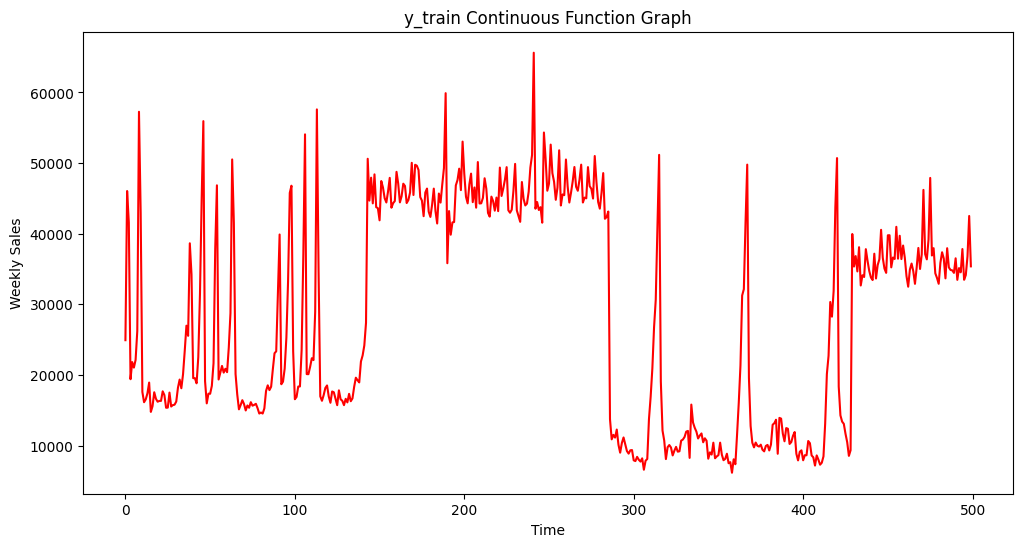

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_train is a pandas Series or a numpy array
plt.figure(figsize=(12, 6))
plt.plot(y_train[:500], color='red')
plt.title('y_train Continuous Function Graph')
plt.xlabel('Time')
plt.ylabel('Weekly Sales')
plt.show()

## Model 0 - Naive Model

🐈 To create the naive model, just shift the data for one place.

In [350]:
# Shift the data and drop empty rows to create naive model.
naive_forecast = y_test.shift(1)
naive_forecast = naive_forecast.dropna()
naive_forecast.head()

,Weekly_Sales
1,2000.0
2,6887.0
3,2851.0
4,3021.0
5,5686.0


In [ ]:
naive_forecast = naive_forecast.reset_index(drop=True)
naive_forecast.head() # As before, index reseting is for making it easier to
# plot the data.

,Weekly_Sales
0,4696.0
1,3943.0
2,2000.0
3,6887.0
4,2851.0


In [ ]:
y_test.head()

,Weekly_Sales
0,4696.0
1,3943.0
2,2000.0
3,6887.0
4,2851.0


### Visualize Predictions of Naive Model vs Real Values
🐈 It's easy to see how wrong predictions are when plotted.

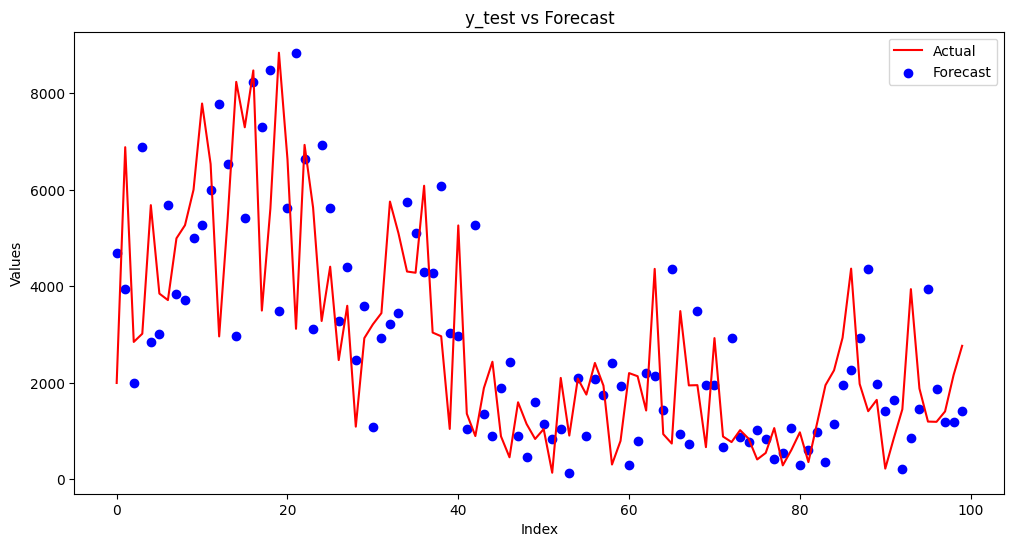

In [ ]:
# Helper function to make it easier to compare y_test value and forecasted values.
def compare_forecast_with_true(y_test, forecast):
  plt.figure(figsize=(12, 6))
  # Using 100 values, if the number of values is too big, it's hard to understand
  # the graph.
  plt.plot(y_test[:100], label='Actual', color='red')

  plt.scatter(list(range(100)), forecast[:100], label='Forecast', color='blue')

  # Add labels and title
  plt.xlabel('Index')
  plt.ylabel('Values')
  plt.title('y_test vs Forecast')

  # Add a legend
  plt.legend()

  # Show the plot
  plt.show()

compare_forecast_with_true(y_test, naive_forecast)

### Evaluate Performance of Naive Model
🐈 Performances will be kept in variables and used at the end of the notebook to compare models.

In [351]:
import tensorflow as tf
baseline_score = tf.keras.metrics.mean_squared_error(y_test[1:], naive_forecast)
baseline_score.numpy()

43582351.826669924

## Creating Window

In [ ]:
def add_lagged_features(df, window_size):
    # Create windows for Weekly_Sales
    for i in range(1, window_size + 1):
        df[f'lag_{i}'] = df['Weekly_Sales'].shift(i)

    # Drop rows with NaN values (due to shifting)
    df = df.dropna()

    return df

window_size = 7  # Define the window size

train_df_copy = train_df.copy()  # Create a copy of the DataFrame (because it
# changes if you pass it directly to function).

# Created windowed DataFrame
windowed_df = add_lagged_features(train_df_copy, window_size)

windowed_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,1,1,2010-03-26,26229.21,False,51.45,2.732,211.018042,8.106,A,151315,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
8,1,1,2010-04-02,57258.43,False,62.27,2.719,210.820450,7.808,A,151315,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
9,1,1,2010-04-09,42960.91,False,65.86,2.770,210.622857,7.808,A,151315,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
10,1,1,2010-04-16,17596.96,False,66.32,2.808,210.488700,7.808,A,151315,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54
11,1,1,2010-04-23,16145.35,False,64.84,2.795,210.439123,7.808,A,151315,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90


In [ ]:
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


### Create Windowed Train Test Sets

In [ ]:
train_len = int(len(windowed_df) * 0.8)
# Split training data into training and test sets
train_data = windowed_df.iloc[:train_len]
test_data = windowed_df.iloc[train_len:]

# Prepare X and y for training and testing
X_train = train_data.drop('Weekly_Sales', axis=1)
y_train = train_data['Weekly_Sales']

X_test = test_data.drop('Weekly_Sales', axis=1)
y_test = test_data['Weekly_Sales']

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (336164, 17)
y_train shape: (336164,)
X_test shape: (84041, 17)
y_test shape: (84041,)


In [ ]:
# Resetting indexes
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [ ]:
X_train.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,1,1,2010-03-26,False,51.45,2.732,211.018042,8.106,A,151315,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
1,1,1,2010-04-02,False,62.27,2.719,210.820450,7.808,A,151315,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
2,1,1,2010-04-09,False,65.86,2.770,210.622857,7.808,A,151315,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
3,1,1,2010-04-16,False,66.32,2.808,210.488700,7.808,A,151315,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54
4,1,1,2010-04-23,False,64.84,2.795,210.439123,7.808,A,151315,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90


In [ ]:
y_train.head()

,Weekly_Sales
0,26229.21
1,57258.43
2,42960.91
3,17596.96
4,16145.35


In [ ]:
X_test.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,35,58,2010-04-16,False,54.95,2.899,135.827250,9.051,B,103681,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,3658.0
1,35,58,2010-04-23,False,53.91,2.902,135.872167,9.051,B,103681,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0
2,35,58,2010-04-30,False,53.55,2.921,135.917083,9.051,B,103681,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0
3,35,58,2010-05-07,False,69.02,2.966,135.962000,9.051,B,103681,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0
4,35,58,2010-05-14,False,53.82,2.982,136.010394,9.051,B,103681,3021.0,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0


In [ ]:
y_test.head()

,Weekly_Sales
0,2000.0
1,6887.0
2,2851.0
3,3021.0
4,5686.0


### Adding Year, Month and Day Features
🐈 These values can be important when predicting future values, so rather than dropping Date column, I divide it into Year, Month and Day and add to DataFrame as features, then I drop it.

In [ ]:
X_test['Date'] = pd.to_datetime(X_test['Date'])

# Extract date features
X_test['Year'] = X_test['Date'].dt.year
X_test['Month'] = X_test['Date'].dt.month
X_test['Day'] = X_test['Date'].dt.day
X_test = X_test.drop(columns=['Date'])
X_test.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Year,Month,Day
0,35,58,False,54.95,2.899,135.827250,9.051,B,103681,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,3658.0,2010,4,16
1,35,58,False,53.91,2.902,135.872167,9.051,B,103681,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,2010,4,23
2,35,58,False,53.55,2.921,135.917083,9.051,B,103681,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,2010,4,30
3,35,58,False,69.02,2.966,135.962000,9.051,B,103681,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,2010,5,7
4,35,58,False,53.82,2.982,136.010394,9.051,B,103681,3021.0,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,2010,5,14


In [ ]:
X_train['Date'] = pd.to_datetime(X_train['Date'])

# Extract date features
X_train['Year'] = X_train['Date'].dt.year
X_train['Month'] = X_train['Date'].dt.month
X_train['Day'] = X_train['Date'].dt.day
X_train = X_train.drop(columns=['Date'])
X_train.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Year,Month,Day
0,1,1,False,51.45,2.732,211.018042,8.106,A,151315,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50,2010,3,26
1,1,1,False,62.27,2.719,210.820450,7.808,A,151315,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,2010,4,2
2,1,1,False,65.86,2.770,210.622857,7.808,A,151315,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,2010,4,9
3,1,1,False,66.32,2.808,210.488700,7.808,A,151315,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,2010,4,16
4,1,1,False,64.84,2.795,210.439123,7.808,A,151315,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,2010,4,23


🐈 Turning IsHoliday from boolean to numerical to be able to put into models.

In [ ]:
X_test['IsHoliday'] = X_test['IsHoliday'].astype(int)
X_train['IsHoliday'] = X_train['IsHoliday'].astype(int)
X_test.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Year,Month,Day
0,35,58,0,54.95,2.899,135.827250,9.051,B,103681,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,3658.0,2010,4,16
1,35,58,0,53.91,2.902,135.872167,9.051,B,103681,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,2010,4,23
2,35,58,0,53.55,2.921,135.917083,9.051,B,103681,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,2010,4,30
3,35,58,0,69.02,2.966,135.962000,9.051,B,103681,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,2010,5,7
4,35,58,0,53.82,2.982,136.010394,9.051,B,103681,3021.0,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,2010,5,14


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336164 entries, 0 to 336163
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         336164 non-null  int64  
 1   Dept          336164 non-null  int64  
 2   IsHoliday     336164 non-null  int64  
 3   Temperature   336164 non-null  float64
 4   Fuel_Price    336164 non-null  float64
 5   CPI           336164 non-null  float64
 6   Unemployment  336164 non-null  float64
 7   Type          336164 non-null  object 
 8   Size          336164 non-null  int64  
 9   lag_1         336164 non-null  float64
 10  lag_2         336164 non-null  float64
 11  lag_3         336164 non-null  float64
 12  lag_4         336164 non-null  float64
 13  lag_5         336164 non-null  float64
 14  lag_6         336164 non-null  float64
 15  lag_7         336164 non-null  float64
 16  Year          336164 non-null  int32  
 17  Month         336164 non-null  int32  
 18  Day 

🐈 Turning IsHoliday from string to numerical to be able to put into models.

In [ ]:
X_test['Type'] = X_test['Type'].astype('category').cat.codes
X_train['Type'] = X_train['Type'].astype('category').cat.codes
X_test.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,Year,Month,Day
0,35,58,0,54.95,2.899,135.827250,9.051,1,103681,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,3658.0,2010,4,16
1,35,58,0,53.91,2.902,135.872167,9.051,1,103681,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,4115.0,2010,4,23
2,35,58,0,53.55,2.921,135.917083,9.051,1,103681,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,3885.0,2010,4,30
3,35,58,0,69.02,2.966,135.962000,9.051,1,103681,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,4293.0,2010,5,7
4,35,58,0,53.82,2.982,136.010394,9.051,1,103681,3021.0,2851.0,6887.0,2000.0,3943.0,4696.0,1706.0,2010,5,14


❗ As I said earlier, these columns are not numerical normally, they represent class-like features numerically. For this reason, models should be able to handle them in a different way. I will use embedding for that. To put them in embedding, separately from the other features, I extract them.

In [ ]:
# Separating class-like features and numerical values.
X_train_store = X_train[['Store']].values
X_train_dept = X_train[['Dept']].values
X_train_type = X_train[['Type']].values
X_train_other = X_train[['IsHoliday',	'Temperature',	'Fuel_Price', 'CPI',
                         'Unemployment',	'Size',	'lag_1',	'lag_2',	'lag_3',
                         'lag_4',	'lag_5', 'lag_6',	'lag_7',	'Year',	'Month',
                         'Day']].values

In [ ]:
X_test_store = X_test[['Store']].values
X_test_dept = X_test[['Dept']].values
X_test_type = X_test[['Type']].values
X_test_other = X_test[['IsHoliday',	'Temperature',	'Fuel_Price', 'CPI',
                       'Unemployment',	'Size',	'lag_1',	'lag_2',	'lag_3',
                       'lag_4',	'lag_5', 'lag_6',	'lag_7',	'Year',	'Month',
                       'Day']].values

In [ ]:
# Checking shapes for input layer's shape parameter.
X_train_store.shape, X_train_dept.shape, X_train_type.shape, X_train_other.shape

((336164, 1), (336164, 1), (336164, 1), (336164, 16))

In [ ]:
# Checking different values for embedding layer's input_dim parameter.
unique_values_dept_train = np.unique(X_train_dept)
unique_values_store_train = np.unique(X_train_store)
unique_values_type_train = np.unique(X_train_type)

unique_values_dept_test = np.unique(X_test_dept)
unique_values_store_test = np.unique(X_test_store)
unique_values_type_test = np.unique(X_test_type)

unique_values_dept_train, unique_values_store_train, unique_values_type_train,
unique_values_dept_test, unique_values_store_test, unique_values_type_test

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
        83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35]),
 array([0, 1, 2], dtype=int8),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 40, 41, 42, 44, 45, 46, 47, 48, 49, 51, 52, 54, 55, 56,
        58, 59, 60, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 85, 87, 90,
        91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 array([0, 1, 2], dtype=int8))

## Model 1 - Window 7 Horizon 1 Dense Model
🐈 This model takes features and last 7 weeks sales and predicts next week's sales based off of them. Only has 2 dense layers as learning layers. That's one of the simplest models that can be created, that's why I've created that as the first deep learning model. Every next model will be bigger than this one.

In [ ]:
from tensorflow.keras import layers
# Input layers. The shape values ​​come from the values ​​shown in 2 cells above.
store_input = layers.Input(shape=(1,), dtype='int32', name='store_input')
dept_input = layers.Input(shape=(1,), dtype='int32', name='dept_input')
type_input = layers.Input(shape=(1,), dtype='int32', name='type_input')
other_inputs = layers.Input(shape=(16,), dtype='float32', name='other_inputs')

# Embedding layers for categorical inputs. The input dim values ​​come from the
# values ​​shown in the cell above.
store_embedding = layers.Embedding(input_dim=46, output_dim=10, input_length=1)(store_input)
dept_embedding = layers.Embedding(input_dim=100, output_dim=10, input_length=1)(dept_input)
type_embedding = layers.Embedding(input_dim=3, output_dim=5, input_length=1)(type_input)

# Flatten the embedding layers
store_embedding_flat = layers.Flatten()(store_embedding)
dept_embedding_flat = layers.Flatten()(dept_embedding)
type_embedding_flat = layers.Flatten()(type_embedding)

# Concatenate embeddings with other numerical inputs
concatenated = layers.Concatenate()([store_embedding_flat, dept_embedding_flat,
                                     type_embedding_flat, other_inputs])

# Dense layers for processing
x = layers.Dense(64, activation='relu')(concatenated)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1)(x)  # Horizon is 1

model_1 = tf.keras.models.Model(inputs=[store_input, dept_input, type_input,
                                        other_inputs], outputs=output)

In [ ]:
# Compiling the model.
model_1.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mean_squared_error'])

In [ ]:
# Fitting the model.
model_1_history = model_1.fit(
    [X_train_store, X_train_dept, X_train_type, X_train_other],  # List of inputs
    y_train,  # Targets
    epochs=20,  # Number of epochs
     callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_1_dense",
                                            verbose=0,
                                            save_best_only=True,
                                  monitor="mean_squared_error")] # Saving best
    # performing epoch. That's for fair comparison.
)

Epoch 1/20
10506/10506 [==============================] - 20s 2ms/step - loss: 43074172.0000 - mean_squared_error: 43074172.0000
Epoch 2/20
10506/10506 [==============================] - 19s 2ms/step - loss: 38864024.0000 - mean_squared_error: 38864024.0000
Epoch 3/20
10506/10506 [==============================] - 18s 2ms/step - loss: 37671100.0000 - mean_squared_error: 37671100.0000
Epoch 4/20
10506/10506 [==============================] - 18s 2ms/step - loss: 37082272.0000 - mean_squared_error: 37082272.0000
Epoch 5/20
10506/10506 [==============================] - 18s 2ms/step - loss: 36704628.0000 - mean_squared_error: 36704628.0000
Epoch 6/20
10506/10506 [==============================] - 18s 2ms/step - loss: 36496104.0000 - mean_squared_error: 36496104.0000
Epoch 7/20
10506/10506 [==============================] - 19s 2ms/step - loss: 35951300.0000 - mean_squared_error: 35951300.0000
Epoch 8/20
10506/10506 [==============================] - 19s 2ms/step - loss: 35829636.0000 - me

In [ ]:
# Evaluating performance of the model and storing it.
model_1 = tf.keras.models.load_model('model_1_dense')
model_1_score = model_1.evaluate([X_test_store, X_test_dept, X_test_type, X_test_other], y_test)
model_1_score

2627/2627 [==============================] - 4s 1ms/step - loss: 24075044.0000 - mean_squared_error: 24075044.0000


[24075044.0, 24075044.0]

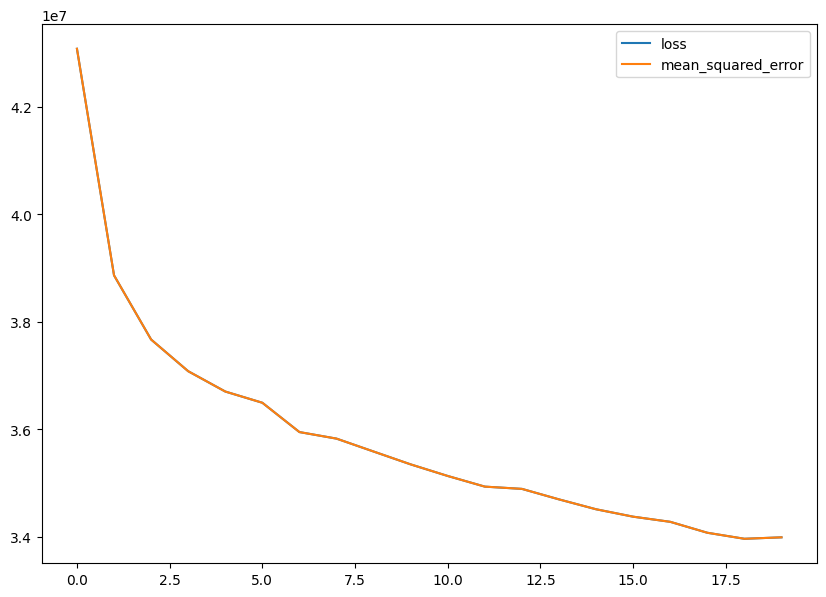

In [ ]:
# Visualizing performance of the model while training.
import pandas as pd
pd.DataFrame(model_1_history.history).plot(figsize=(10, 7));

2627/2627 [==============================] - 3s 1ms/step


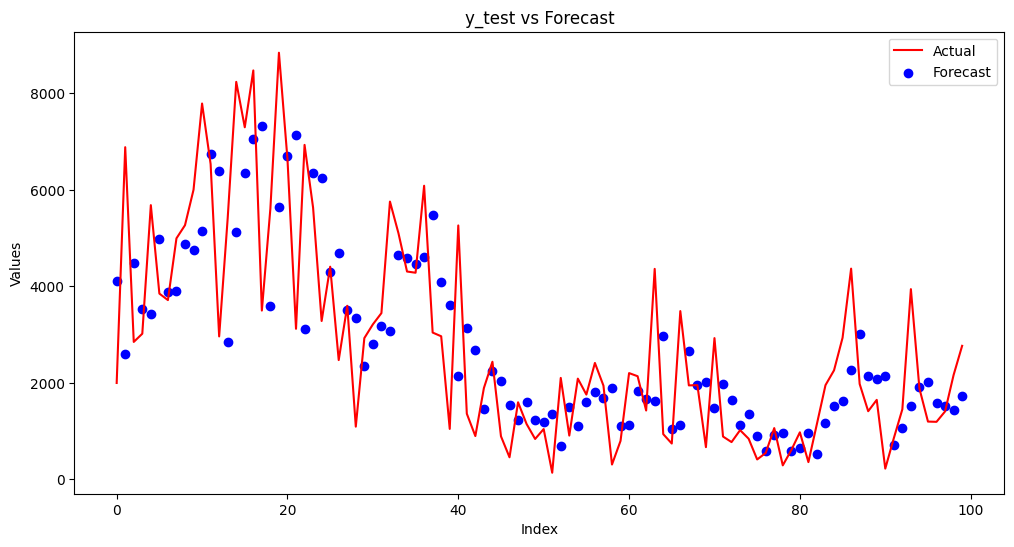

In [ ]:
# Visualizing model's prediction vs real values
model_1_preds = model_1.predict([X_test_store, X_test_dept, X_test_type, X_test_other])
compare_forecast_with_true(y_test, model_1_preds)

## Model 2 - Window 30 Horizan 1 Dense Model

### Change Window Size
🐈 First, I'll change window size to 30.

In [ ]:
window_size = 30

train_df_copy = train_df.copy()

# Apply the function to your DataFrame
windowed_df_30 = add_lagged_features(train_df_copy, window_size)

windowed_df_30.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
30,1,1,2010-09-03,16241.78,False,81.21,2.577,211.531248,7.787,A,...,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
31,1,1,2010-09-10,18194.74,True,78.69,2.565,211.495190,7.787,A,...,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
32,1,1,2010-09-17,19354.23,False,82.11,2.582,211.522460,7.787,A,...,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
33,1,1,2010-09-24,18122.52,False,80.94,2.624,211.597225,7.787,A,...,16555.11,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54
34,1,1,2010-10-01,20094.19,False,71.89,2.603,211.671989,7.838,A,...,17413.94,16555.11,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90


### Creating Window Size 30 Train Test Sets

In [ ]:
train_len_30 = int(len(windowed_df_30) * 0.8)
# Split training data into training and test sets
train_data_30 = windowed_df_30.iloc[:train_len_30]
test_data_30 = windowed_df_30.iloc[train_len_30:]

# Prepare X and y for training and testing
X_train_30 = train_data_30.drop('Weekly_Sales', axis=1)
y_train_30 = train_data_30['Weekly_Sales']

X_test_30 = test_data_30.drop('Weekly_Sales', axis=1)
y_test_30 = test_data_30['Weekly_Sales']

print(f"X_train_30 shape: {X_train_30.shape}")
print(f"y_train_30 shape: {y_train_30.shape}")
print(f"X_test_30 shape: {X_test_30.shape}")
print(f"y_test_30 shape: {y_test_30.shape}")

X_train_30 shape: (336145, 40)
y_train_30 shape: (336145,)
X_test_30 shape: (84037, 40)
y_test_30 shape: (84037,)


In [ ]:
# Resetting indexes
y_train_30 = y_train_30.reset_index(drop=True)
y_test_30 = y_test_30.reset_index(drop=True)
X_train_30 = X_train_30.reset_index(drop=True)
X_test_30 = X_test_30.reset_index(drop=True)

In [ ]:
X_train_30.head()

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
0,1,1,2010-09-03,False,81.21,2.577,211.531248,7.787,A,151315,...,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50
1,1,1,2010-09-10,True,78.69,2.565,211.495190,7.787,A,151315,...,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49
2,1,1,2010-09-17,False,82.11,2.582,211.522460,7.787,A,151315,...,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55
3,1,1,2010-09-24,False,80.94,2.624,211.597225,7.787,A,151315,...,16555.11,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54
4,1,1,2010-10-01,False,71.89,2.603,211.671989,7.838,A,151315,...,17413.94,16555.11,16145.35,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90


### Adding Year, Month and Day as Features (Again)

In [ ]:
X_test_30['Date'] = pd.to_datetime(X_test_30['Date'])

# Extract date features
X_test_30['Year'] = X_test_30['Date'].dt.year
X_test_30['Month'] = X_test_30['Date'].dt.month
X_test_30['Day'] = X_test_30['Date'].dt.day
X_test_30 = X_test_30.drop(columns=['Date'])
X_test_30.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,Year,Month,Day
0,35,58,False,53.82,2.982,136.010394,9.051,B,103681,3021.0,...,430.84,427.68,101.85,10.00,28.06,177.80,189.60,2010,5,14
1,35,58,False,63.31,2.958,136.079652,9.051,B,103681,5686.0,...,146.52,430.84,427.68,101.85,10.00,28.06,177.80,2010,5,21
2,35,58,False,67.88,2.899,136.148910,9.051,B,103681,3853.0,...,281.97,146.52,430.84,427.68,101.85,10.00,28.06,2010,5,28
3,35,58,False,74.29,2.847,136.218168,9.051,B,103681,3718.0,...,444.28,281.97,146.52,430.84,427.68,101.85,10.00,2010,6,4
4,35,58,False,68.90,2.809,136.287426,9.051,B,103681,4998.0,...,329.10,444.28,281.97,146.52,430.84,427.68,101.85,2010,6,11


In [ ]:
X_train_30['Date'] = pd.to_datetime(X_train_30['Date'])

# Extract date features
X_train_30['Year'] = X_train_30['Date'].dt.year
X_train_30['Month'] = X_train_30['Date'].dt.month
X_train_30['Day'] = X_train_30['Date'].dt.day
X_train_30 = X_train_30.drop(columns=['Date'])
X_train_30.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,Year,Month,Day
0,1,1,False,81.21,2.577,211.531248,7.787,A,151315,15793.87,...,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,24924.50,2010,9,3
1,1,1,True,78.69,2.565,211.495190,7.787,A,151315,16241.78,...,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,46039.49,2010,9,10
2,1,1,False,82.11,2.582,211.522460,7.787,A,151315,18194.74,...,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,41595.55,2010,9,17
3,1,1,False,80.94,2.624,211.597225,7.787,A,151315,19354.23,...,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,19403.54,2010,9,24
4,1,1,False,71.89,2.603,211.671989,7.838,A,151315,18122.52,...,17596.96,42960.91,57258.43,26229.21,22136.64,21043.39,21827.90,2010,10,1


In [ ]:
# Numerilizing IsHoliday
X_test_30['IsHoliday'] = X_test_30['IsHoliday'].astype(int)
X_train_30['IsHoliday'] = X_train_30['IsHoliday'].astype(int)
X_test_30.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,Year,Month,Day
0,35,58,0,53.82,2.982,136.010394,9.051,B,103681,3021.0,...,430.84,427.68,101.85,10.00,28.06,177.80,189.60,2010,5,14
1,35,58,0,63.31,2.958,136.079652,9.051,B,103681,5686.0,...,146.52,430.84,427.68,101.85,10.00,28.06,177.80,2010,5,21
2,35,58,0,67.88,2.899,136.148910,9.051,B,103681,3853.0,...,281.97,146.52,430.84,427.68,101.85,10.00,28.06,2010,5,28
3,35,58,0,74.29,2.847,136.218168,9.051,B,103681,3718.0,...,444.28,281.97,146.52,430.84,427.68,101.85,10.00,2010,6,4
4,35,58,0,68.90,2.809,136.287426,9.051,B,103681,4998.0,...,329.10,444.28,281.97,146.52,430.84,427.68,101.85,2010,6,11


In [ ]:
# Numerilizing Type
X_test_30['Type'] = X_test_30['Type'].astype('category').cat.codes
X_train_30['Type'] = X_train_30['Type'].astype('category').cat.codes
X_test_30.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,lag_1,...,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,Year,Month,Day
0,35,58,0,53.82,2.982,136.010394,9.051,1,103681,3021.0,...,430.84,427.68,101.85,10.00,28.06,177.80,189.60,2010,5,14
1,35,58,0,63.31,2.958,136.079652,9.051,1,103681,5686.0,...,146.52,430.84,427.68,101.85,10.00,28.06,177.80,2010,5,21
2,35,58,0,67.88,2.899,136.148910,9.051,1,103681,3853.0,...,281.97,146.52,430.84,427.68,101.85,10.00,28.06,2010,5,28
3,35,58,0,74.29,2.847,136.218168,9.051,1,103681,3718.0,...,444.28,281.97,146.52,430.84,427.68,101.85,10.00,2010,6,4
4,35,58,0,68.90,2.809,136.287426,9.051,1,103681,4998.0,...,329.10,444.28,281.97,146.52,430.84,427.68,101.85,2010,6,11


In [ ]:
# Separating class-like features and numerical values and checking their shapes
# for model's input parameters.
X_train_store_30 = X_train_30[['Store']].values
X_train_dept_30 = X_train_30[['Dept']].values
X_train_type_30 = X_train_30[['Type']].values
X_train_other_30 = X_train_30.drop(columns=['Store', 'Dept', 'Type']).values

X_test_store_30 = X_test_30[['Store']].values
X_test_dept_30 = X_test_30[['Dept']].values
X_test_type_30 = X_test_30[['Type']].values
X_test_other_30 = X_test_30.drop(columns=['Store', 'Dept', 'Type']).values

X_train_other_30.shape, X_train_store_30.shape, X_train_dept_30.shape, X_train_type_30.shape

((336145, 39), (336145, 1), (336145, 1), (336145, 1))

### Creating the Model
🐈 Model is the same as model 1, only thing that changed is window size.

In [ ]:
from tensorflow.keras import layers
store_input = layers.Input(shape=(1,), dtype='int32', name='store_input')
dept_input = layers.Input(shape=(1,), dtype='int32', name='dept_input')
type_input = layers.Input(shape=(1,), dtype='int32', name='type_input')
other_inputs = layers.Input(shape=(39,), dtype='float32', name='other_inputs')

# Embedding layers for categorical inputs
store_embedding = layers.Embedding(input_dim=46, output_dim=10, input_length=1)(store_input)
dept_embedding = layers.Embedding(input_dim=100, output_dim=10, input_length=1)(dept_input)
type_embedding = layers.Embedding(input_dim=3, output_dim=5, input_length=1)(type_input)

# Flatten the embedding layers
store_embedding_flat = layers.Flatten()(store_embedding)
dept_embedding_flat = layers.Flatten()(dept_embedding)
type_embedding_flat = layers.Flatten()(type_embedding)

# Concatenate embeddings with other numerical inputs
concatenated = layers.Concatenate()([store_embedding_flat, dept_embedding_flat, type_embedding_flat, other_inputs])

# Dense layers for processing
x = layers.Dense(64, activation='relu')(concatenated)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(1)(x)  #Horizon is 1

model_2 = tf.keras.models.Model(inputs=[store_input, dept_input, type_input, other_inputs], outputs=output)

In [ ]:
# Compiling the model.
model_2.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mean_squared_error'])

In [248]:
# Fitting the model.
model_2_history = model_2.fit(
    [X_train_store_30, X_train_dept_30, X_train_type_30, X_train_other_30],  # List of inputs
    y_train_30,  # Targets
    epochs=20,  # Number of epochs
     callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_2_dense",
                                            verbose=1,
                                            save_best_only=True,
                                  monitor="mean_squared_error")]# Saving best
    # performing epoch. That's for fair comparison.

)

Epoch 1/20
10505/10505 [==============================] - ETA: 0s - loss: 43663404.0000 - mean_squared_error: 43663404.0000
Epoch 1: mean_squared_error improved from inf to 43663404.00000, saving model to model_2_dense
10505/10505 [==============================] - 20s 2ms/step - loss: 43663404.0000 - mean_squared_error: 43663404.0000
Epoch 2/20
10502/10505 [============================>.] - ETA: 0s - loss: 38503640.0000 - mean_squared_error: 38503640.0000
Epoch 2: mean_squared_error improved from 43663404.00000 to 38500464.00000, saving model to model_2_dense
10505/10505 [==============================] - 19s 2ms/step - loss: 38500464.0000 - mean_squared_error: 38500464.0000
Epoch 3/20
10499/10505 [============================>.] - ETA: 0s - loss: 37066880.0000 - mean_squared_error: 37066880.0000
Epoch 3: mean_squared_error improved from 38500464.00000 to 37059648.00000, saving model to model_2_dense
10505/10505 [==============================] - 20s 2ms/step - loss: 37059648.0000 - m

In [249]:
# Evaluating performance of the model and storing it.
model_2 = tf.keras.models.load_model('model_2_dense')
model_2_score = model_2.evaluate([X_test_store_30, X_test_dept_30, X_test_type_30, X_test_other_30], y_test_30)
model_2_score

2627/2627 [==============================] - 4s 1ms/step - loss: 23091704.0000 - mean_squared_error: 23091704.0000


[23091704.0, 23091704.0]

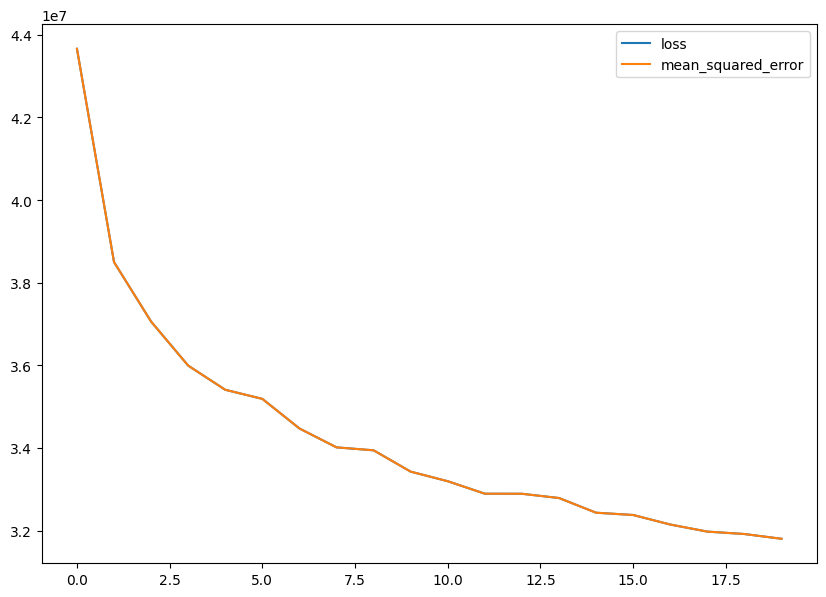

In [250]:
# Visualizing performance of the model while training.
pd.DataFrame(model_2_history.history).plot(figsize=(10, 7));

2627/2627 [==============================] - 4s 1ms/step


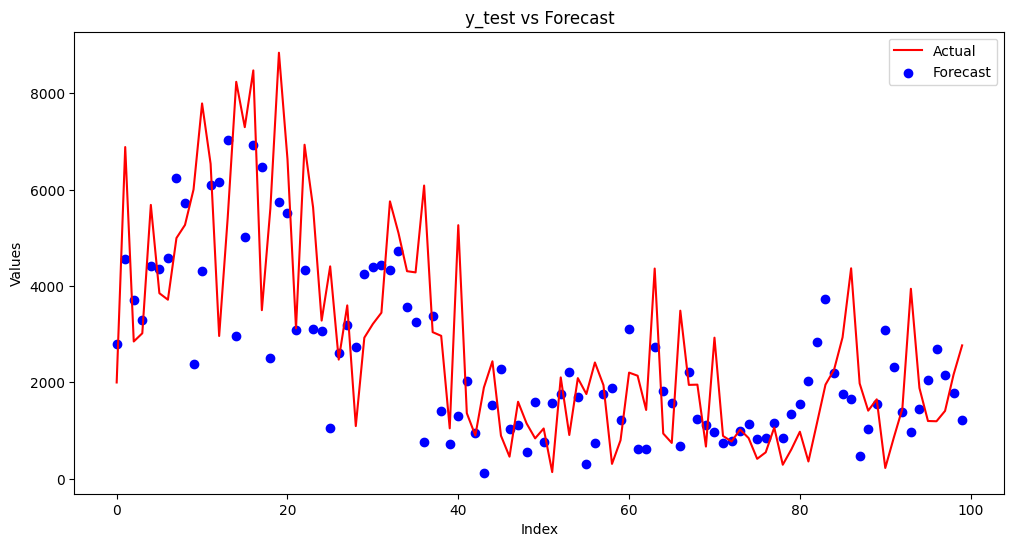

In [251]:
# Visualizing model's prediction vs real values
model_2_preds = model_2.predict([X_test_store_30, X_test_dept_30, X_test_type_30, X_test_other_30])
compare_forecast_with_true(y_test, model_2_preds)

## Model 3 - Window 30 Horizon 7 Dense Model

### Setting Horizon to 7
🐈 Before creating the model, I should process data. Start with creating horizon 7 datasets.

In [ ]:
# Function for creating horizoned datasets.
def create_rolling_windows(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size + 1)])

y_train_7 = create_rolling_windows(y_train_30, 7)
y_test_7 = create_rolling_windows(y_test_30, 7)

In [262]:
X_train_store_7 = X_train_store_30[6:]
X_train_dept_7 = X_train_dept_30[6:]
X_train_type_7 = X_train_type_30[6:]
X_train_other_7 = X_train_other_30[6:]

X_test_store_7 = X_test_store_30[6:]
X_test_dept_7 = X_test_dept_30[6:]
X_test_type_7 = X_test_type_30[6:]
X_test_other_7 = X_test_other_30[6:]

🐈 Because y values are horizoned, there are less values in them now. So, I changed X values accordingly.

In [ ]:
# Show how horizon works
y_train_7[-5:], y_train[-5:]

(array([[3658., 4115., 3885., 4293., 1706., 4696., 3943.],
        [4115., 3885., 4293., 1706., 4696., 3943., 2000.],
        [3885., 4293., 1706., 4696., 3943., 2000., 6887.],
        [4293., 1706., 4696., 3943., 2000., 6887., 2851.],
        [1706., 4696., 3943., 2000., 6887., 2851., 3021.]]),
 336159    3885.0
 336160    4293.0
 336161    1706.0
 336162    4696.0
 336163    3943.0
 Name: Weekly_Sales, dtype: float64)

In [263]:
# Check shapes for model's input shapes.
y_train_7.shape, y_test_7.shape, X_train_store_7.shape, X_test_store_7.shape

((336139, 7), (84031, 7), (336139, 1), (84031, 1))

### Creating the Model
🐈 This model is the same as model 1 too. Only feature that changed is, now it predicts next 7 weeks instead of 1.

In [252]:
from tensorflow.keras import layers
store_input = layers.Input(shape=(1,), dtype='int32', name='store_input')
dept_input = layers.Input(shape=(1,), dtype='int32', name='dept_input')
type_input = layers.Input(shape=(1,), dtype='int32', name='type_input')
other_inputs = layers.Input(shape=(39,), dtype='float32', name='other_inputs')

# Embedding layers for categorical inputs
store_embedding = layers.Embedding(input_dim=46, output_dim=10, input_length=1)(store_input)
dept_embedding = layers.Embedding(input_dim=100, output_dim=10, input_length=1)(dept_input)
type_embedding = layers.Embedding(input_dim=3, output_dim=5, input_length=1)(type_input)

# Flatten the embedding layers
store_embedding_flat = layers.Flatten()(store_embedding)
dept_embedding_flat = layers.Flatten()(dept_embedding)
type_embedding_flat = layers.Flatten()(type_embedding)

# Concatenate embeddings with other numerical inputs
concatenated = layers.Concatenate()([store_embedding_flat, dept_embedding_flat, type_embedding_flat, other_inputs])

# Dense layers for processing
x = layers.Dense(64, activation='relu')(concatenated)
x = layers.Dense(32, activation='relu')(x)
output = layers.Dense(7)(x)  # Horizan is 7

model_3 = tf.keras.models.Model(inputs=[store_input, dept_input, type_input, other_inputs], outputs=output)

In [253]:
# Compiling the model.
model_3.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mean_squared_error'])

In [264]:
# Fitting the model.
model_3_history = model_3.fit(
    [X_train_store_7, X_train_dept_7, X_train_type_7, X_train_other_7],  # List of inputs
    y_train_7,  # Targets
    epochs=20,  # Number of epochs
     callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_3_dense_7_days",
                                            verbose=1,
                                            save_best_only=True,
                                  monitor="mean_squared_error")]# Saving best
    # performing epoch. That's for fair comparison.

)

Epoch 1/20
10497/10505 [============================>.] - ETA: 0s - loss: 11889796.0000 - mean_squared_error: 11889796.0000
Epoch 1: mean_squared_error improved from inf to 11883668.00000, saving model to model_3_dense_7_days
10505/10505 [==============================] - 20s 2ms/step - loss: 11883668.0000 - mean_squared_error: 11883668.0000
Epoch 2/20
10481/10505 [============================>.] - ETA: 0s - loss: 6479115.5000 - mean_squared_error: 6479115.5000
Epoch 2: mean_squared_error improved from 11883668.00000 to 6477537.50000, saving model to model_3_dense_7_days
10505/10505 [==============================] - 20s 2ms/step - loss: 6477537.5000 - mean_squared_error: 6477537.5000
Epoch 3/20
10482/10505 [============================>.] - ETA: 0s - loss: 6074903.5000 - mean_squared_error: 6074903.5000
Epoch 3: mean_squared_error improved from 6477537.50000 to 6070337.00000, saving model to model_3_dense_7_days
10505/10505 [==============================] - 20s 2ms/step - loss: 60703

In [265]:
# Evaluating performance of the model and storing it.
model_3 = tf.keras.models.load_model('model_3_dense_7_days')
model_3_score = model_3.evaluate([X_test_store_7, X_test_dept_7, X_test_type_7, X_test_other_7], y_test_7)
model_3_score

2626/2626 [==============================] - 4s 1ms/step - loss: 3624582.7500 - mean_squared_error: 3624582.7500


[3624582.75, 3624582.75]

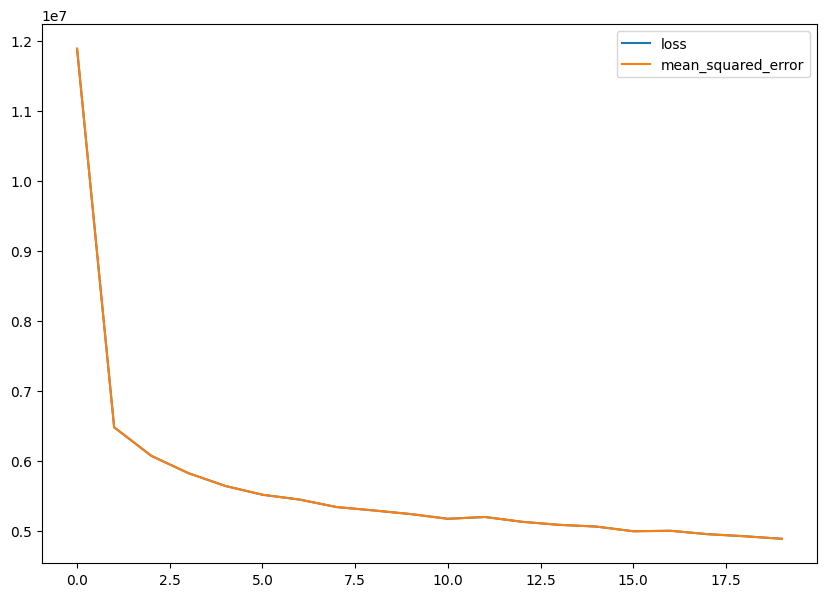

In [266]:
# Visualizing performance of the model while training.
pd.DataFrame(model_3_history.history).plot(figsize=(10, 7));

❗ Starting from here, we can't plot forecasted values vs real values. That's because horizon is 7, the graph will be unreadable. That's why I won't include it after models from now on.

## Model 4 - Window 30 Horizon 7 LSTM
🐈 This model is significantly bigger than the previous ones. It includes 2 LSTM layers that have 512 and 256 units, and dense layers that have 1024 and 512 units as learning layers. It also has average pooling layers of LSTMs.

🐈 Tried to train the model with and without average pooling, the model that includes it gives better results. That's why I kept it.

In [335]:
from tensorflow.keras import layers
store_input = layers.Input(shape=(1,), dtype='int32', name='store_input')
dept_input = layers.Input(shape=(1,), dtype='int32', name='dept_input')
type_input = layers.Input(shape=(1,), dtype='int32', name='type_input')
other_inputs = layers.Input(shape=(39,), dtype='float32', name='other_inputs')

# Embedding layers for categorical inputs
store_embedding = layers.Embedding(input_dim=46, output_dim=10, input_length=1)(store_input)
dept_embedding = layers.Embedding(input_dim=100, output_dim=10, input_length=1)(dept_input)
type_embedding = layers.Embedding(input_dim=3, output_dim=5, input_length=1)(type_input)

# Flatten the embedding layers
store_embedding_flat = layers.Flatten()(store_embedding)
dept_embedding_flat = layers.Flatten()(dept_embedding)
type_embedding_flat = layers.Flatten()(type_embedding)

# Concatenate embeddings with other numerical inputs
concatenated = layers.Concatenate()([store_embedding_flat, dept_embedding_flat, type_embedding_flat, other_inputs])

concatenated_reshaped = layers.Reshape((1, concatenated.shape[-1]))(concatenated)

# Dense layers for processing
x = layers.LSTM(512, return_sequences=True, activation="relu")(concatenated_reshaped)
x = layers.LSTM(256, return_sequences=True, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(7)(x)  # Horizon is 7

model_4 = tf.keras.models.Model(inputs=[store_input, dept_input, type_input, other_inputs], outputs=output)

In [336]:
# Compiling the model.
model_4.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mean_squared_error'])

In [337]:
# Fitting the model.
model_4_history = model_4.fit(
    [X_train_store_7, X_train_dept_7, X_train_type_7, X_train_other_7],  # List of inputs
    y_train_7,  # Targets
    epochs=20,  # Number of epochs
     callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_4_lstm_7_days",
                                            verbose=1,
                                            save_best_only=True,
                                  monitor="mean_squared_error"),# Saving best
    # performing epoch. That's for fair comparison.

                       tf.keras.callbacks.ReduceLROnPlateau(monitor='mean_squared_error',
                                                            patience=0)]) # To
    # prevent overfitting.

Epoch 1/20
10502/10505 [============================>.] - ETA: 0s - loss: 17980196.0000 - mean_squared_error: 17980196.0000
Epoch 1: mean_squared_error improved from inf to 17977218.00000, saving model to model_4_lstm_7_days
10505/10505 [==============================] - 144s 13ms/step - loss: 17977218.0000 - mean_squared_error: 17977218.0000 - lr: 0.0010
Epoch 2/20
10504/10505 [============================>.] - ETA: 0s - loss: 8687407.0000 - mean_squared_error: 8687407.0000
Epoch 2: mean_squared_error improved from 17977218.00000 to 8687133.00000, saving model to model_4_lstm_7_days
10505/10505 [==============================] - 143s 14ms/step - loss: 8687133.0000 - mean_squared_error: 8687133.0000 - lr: 0.0010
Epoch 3/20
10503/10505 [============================>.] - ETA: 0s - loss: 7187408.5000 - mean_squared_error: 7187408.5000
Epoch 3: mean_squared_error improved from 8687133.00000 to 7188468.50000, saving model to model_4_lstm_7_days
10505/10505 [==============================] -

In [338]:
# Evaluating performance of the model and storing it.
model_4 = tf.keras.models.load_model('model_4_lstm_7_days')
model_4_score = model_4.evaluate([X_test_store_7, X_test_dept_7, X_test_type_7, X_test_other_7], y_test_7)
model_4_score

2626/2626 [==============================] - 13s 5ms/step - loss: 3578009.2500 - mean_squared_error: 3578009.2500


[3578009.25, 3578009.25]

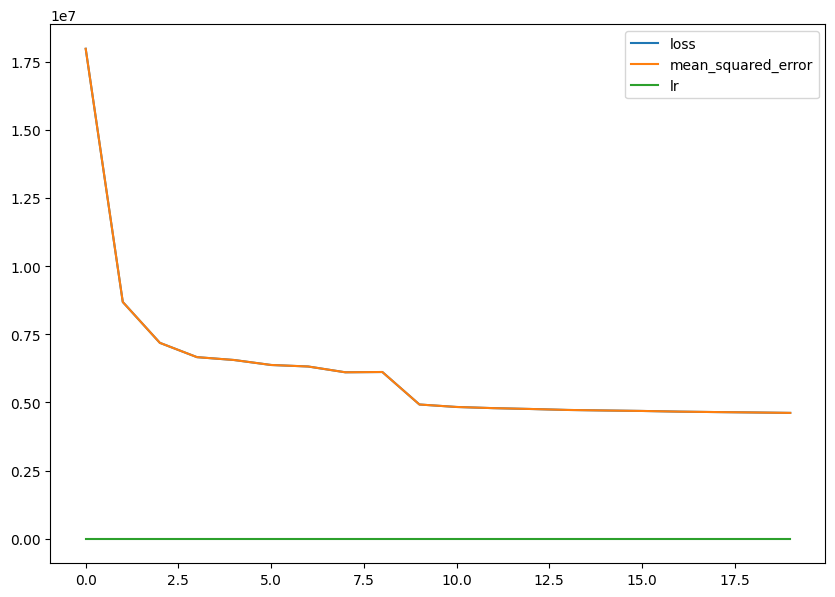

In [340]:
# Visualizing performance of the model while training.
pd.DataFrame(model_4_history.history).plot(figsize=(10, 7));

## Model 5 - Window 30 Horizon 7 GRU Model
🐈 This model's architecture is same as model 4, only change is there are GRU cells instead of LSTMs.

In [341]:
from tensorflow.keras import layers
store_input = layers.Input(shape=(1,), dtype='int32', name='store_input')
dept_input = layers.Input(shape=(1,), dtype='int32', name='dept_input')
type_input = layers.Input(shape=(1,), dtype='int32', name='type_input')
other_inputs = layers.Input(shape=(39,), dtype='float32', name='other_inputs')

# Embedding layers for categorical inputs
store_embedding = layers.Embedding(input_dim=46, output_dim=10, input_length=1)(store_input)
dept_embedding = layers.Embedding(input_dim=100, output_dim=10, input_length=1)(dept_input)
type_embedding = layers.Embedding(input_dim=3, output_dim=5, input_length=1)(type_input)

# Flatten the embedding layers
store_embedding_flat = layers.Flatten()(store_embedding)
dept_embedding_flat = layers.Flatten()(dept_embedding)
type_embedding_flat = layers.Flatten()(type_embedding)

# Concatenate embeddings with other numerical inputs
concatenated = layers.Concatenate()([store_embedding_flat, dept_embedding_flat, type_embedding_flat, other_inputs])

concatenated_reshaped = layers.Reshape((1, concatenated.shape[-1]))(concatenated)

# Dense layers for processing
x = layers.GRU(512, return_sequences=True, activation="relu")(concatenated_reshaped)
x = layers.GRU(256, return_sequences=True, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(7)(x)  # Horizon is 7

model_5 = tf.keras.models.Model(inputs=[store_input, dept_input, type_input, other_inputs], outputs=output)

In [342]:
# Compiling the model.
model_5.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mean_squared_error'])

In [343]:
# Fitting the model.
model_5_history = model_5.fit(
    [X_train_store_7, X_train_dept_7, X_train_type_7, X_train_other_7],  # List of inputs
    y_train_7,  # Targets
    epochs=20,  # Number of epochs
     callbacks=[tf.keras.callbacks.ModelCheckpoint(
                                  filepath="model_5_gru_7_days",
                                            verbose=1,
                                            save_best_only=True,
                                  monitor="mean_squared_error"),# Saving best
    # performing epoch. That's for fair comparison.

                       tf.keras.callbacks.ReduceLROnPlateau(monitor='mean_squared_error',
                                                            patience=0)])# To
    # prevent overfitting.

Epoch 1/20
10501/10505 [============================>.] - ETA: 0s - loss: 14468720.0000 - mean_squared_error: 14468720.0000
Epoch 1: mean_squared_error improved from inf to 14465374.00000, saving model to model_5_gru_7_days
10505/10505 [==============================] - 126s 12ms/step - loss: 14465374.0000 - mean_squared_error: 14465374.0000 - lr: 0.0010
Epoch 2/20
10501/10505 [============================>.] - ETA: 0s - loss: 7898536.5000 - mean_squared_error: 7898536.5000
Epoch 2: mean_squared_error improved from 14465374.00000 to 7897454.00000, saving model to model_5_gru_7_days
10505/10505 [==============================] - 124s 12ms/step - loss: 7897454.0000 - mean_squared_error: 7897454.0000 - lr: 0.0010
Epoch 3/20
10505/10505 [==============================] - ETA: 0s - loss: 7189168.0000 - mean_squared_error: 7189168.0000
Epoch 3: mean_squared_error improved from 7897454.00000 to 7189168.00000, saving model to model_5_gru_7_days
10505/10505 [==============================] - 12

In [344]:
# Evaluating performance of the model and storing it.
model_5 = tf.keras.models.load_model('model_5_gru_7_days')
model_5_score = model_5.evaluate([X_test_store_7, X_test_dept_7, X_test_type_7, X_test_other_7], y_test_7)
model_5_score

2626/2626 [==============================] - 11s 4ms/step - loss: 3321244.7500 - mean_squared_error: 3321244.7500


[3321244.75, 3321244.75]

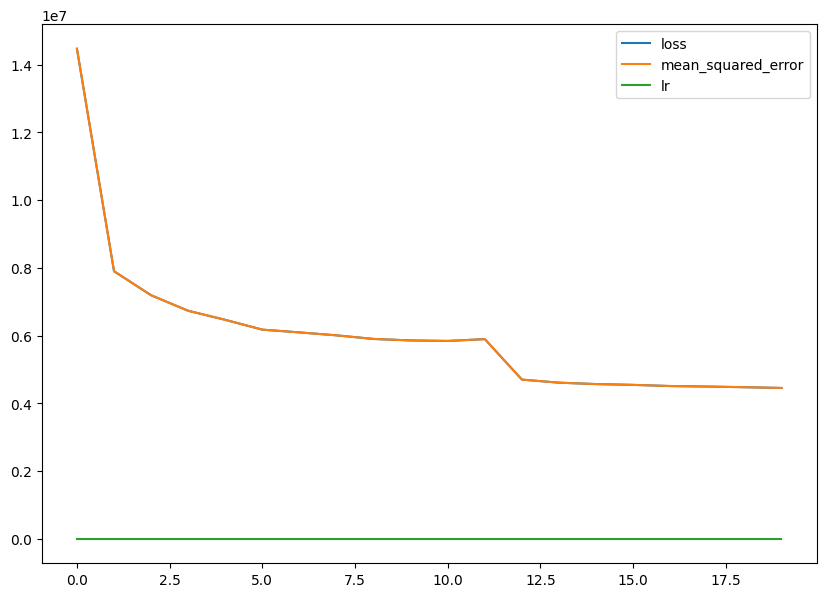

In [345]:
# Visualizing performance of the model while training.
pd.DataFrame(model_5_history.history).plot(figsize=(10, 7));

## Visualizing and Comparing Performance of the Models
🐈 Models and their errors are ready, it's time to compare them and see which one performs the best for this problem.

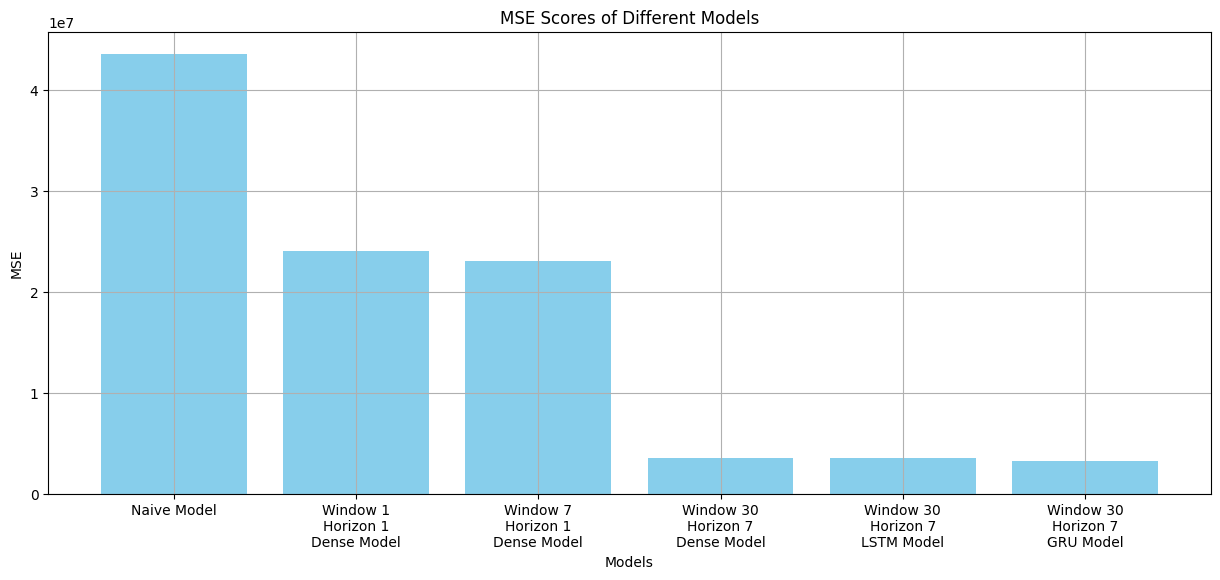

In [348]:
import matplotlib.pyplot as plt
# Taking MSEs of every model (baseline model already has MSE variable)
mse_1 = model_1_score[1]
mse_2 = model_2_score[1]
mse_3 = model_3_score[1]
mse_4 = model_4_score[1]
mse_5 = model_5_score[1]

mse_scores = [baseline_score, mse_1, mse_2, mse_3, mse_4, mse_5]

model_names = ["Naive Model", "Window 1\nHorizon 1\nDense Model", "Window 7\nHorizon 1\nDense Model",
               "Window 30\nHorizon 7\nDense Model", "Window 30\nHorizon 7\nLSTM Model",
               "Window 30\nHorizon 7\nGRU Model"] # Naming the models, new lines to prevent
               # long names write on each other

plt.figure(figsize=(15, 6))
plt.bar(model_names, mse_scores, color='skyblue')

plt.title('MSE Scores of Different Models')
plt.xlabel('Models')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

🐈 It's clear that model 5 (GRU Model) performs the best among them. When we need to forecast new sales, we should use this model.

❗ I tried to use transfer learning too, but it seems like there is no forecasting model on TensorFlow Hub.